<a href="https://colab.research.google.com/github/dmora4/network_measurements_course/blob/main/Tranfer_Learning_for_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set Up
Import all the libraries and functions that we will use.



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
import os
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import log_loss, d2_pinball_score, get_scorer_names
from sklearn.utils import resample

from scipy.stats import ttest_ind, mannwhitneyu, ks_2samp

import math
from sklearn.utils import shuffle


import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_pinball_loss, make_scorer, accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

from google.colab import drive
from os import listdir
from os.path import isfile, join


from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, LeaveOneOut
from pprint import pprint


drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/nda/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Retrieve files from Drive

In [2]:
files = [f for f in listdir(PATH) if isfile(join(PATH, f))]
print(files)

['Dataset_german_17_node.dat', 'Dataset_european_19_node.dat']


In [3]:
def read_dataset(filename):
    span_lengths = []
    link_occupancies = []
    SNR_vect = []

    with open(filename) as data_file:
        next(data_file)
        for line in data_file:

            vals = line.split(";", 3)

            spans = vals[0].split(",")
            spans_list = [int(x) for x in spans]
            span_lengths.append(spans_list)

            occupancies = vals[1].split(',')
            occupancies_list = [int(x) for x in occupancies]
            link_occupancies.append(occupancies_list)

            snr = float(vals[2])
            SNR_vect.append(snr)

    data = pd.DataFrame({'SNR': SNR_vect, 'Span':span_lengths, 'Link':link_occupancies})

    return data

In [4]:
raw_data_g = read_dataset(join(PATH, files[0]))

raw_data_e = read_dataset(join(PATH, files[1]))

Statistical features are extracted from the dataset.

In [5]:
def extract_features(spans, links):
  features_matrix = []
  for s, l in zip(spans, links):
    features = []

    features.append(np.mean(s))
    features.append(np.shape(s)[0])
    features.append(np.max(s))
    features.append(np.min(s))
    features.append(np.std(s))

    features.append(np.mean(l))
    features.append(np.shape(l)[0])
    features.append(np.max(l))
    features.append(np.min(l))
    features.append(np.std(l))

    features_matrix.append(features)

  return np.array(features_matrix)

features_g = extract_features(raw_data_g['Span'], raw_data_g['Link'])
features_e = extract_features(raw_data_e['Span'], raw_data_e['Link'])

### Handling Two Datasets: `data_g` and `data_e`

In [6]:
data_g = pd.DataFrame(features_g)
data_g = data_g.set_axis(['Span', 'Span_Len', 'Span_Max', 'Span_Min', 'Span_Std', 'Link', 'Link_Len', 'Link_Max', 'Link_Min', 'Link_Std'], axis=1, copy=False)
data_e = pd.DataFrame(features_e)
data_e = data_e.set_axis(['Span', 'Span_Len', 'Span_Max', 'Span_Min', 'Span_Std', 'Link', 'Link_Len', 'Link_Max', 'Link_Min', 'Link_Std'], axis=1, copy=False)

data_g['SNR'] = raw_data_g['SNR']
data_e['SNR'] = raw_data_e['SNR']

###SNR -> MF:
Added a small epsilon value to handle values that are exactly at the one of the boundries of the conditional statements. IE, SNR values of 11.0 where previously being recognized as 64 (falling into the last `else` branch).

In [7]:

boundries = [8.7, 12.8, 15.2, 18.2, 21.0]

def SNR_to_MF(SNR):
    epsilon = 1e-6  # Small epsilon value for comparison

    if SNR < boundries[0] - epsilon:
        return 0

    elif (boundries[0] - epsilon <= SNR) and (SNR < boundries[1]):
        return 4

    elif (boundries[1] <= SNR) and (SNR < boundries[2]):
        return 8

    elif (boundries[2] <= SNR) and (SNR < boundries[3]):
        return 16

    elif (boundries[3] <= SNR) and (SNR < boundries[4]):
        return 32

    else:  # SNR >= 23.7:
        return 64

data_g['MF'] = [SNR_to_MF(s) for s in data_g['SNR']]
data_e['MF'] = [SNR_to_MF(s) for s in data_e['SNR']]

###Comparing The Two Domains

####Visually Compare Sets

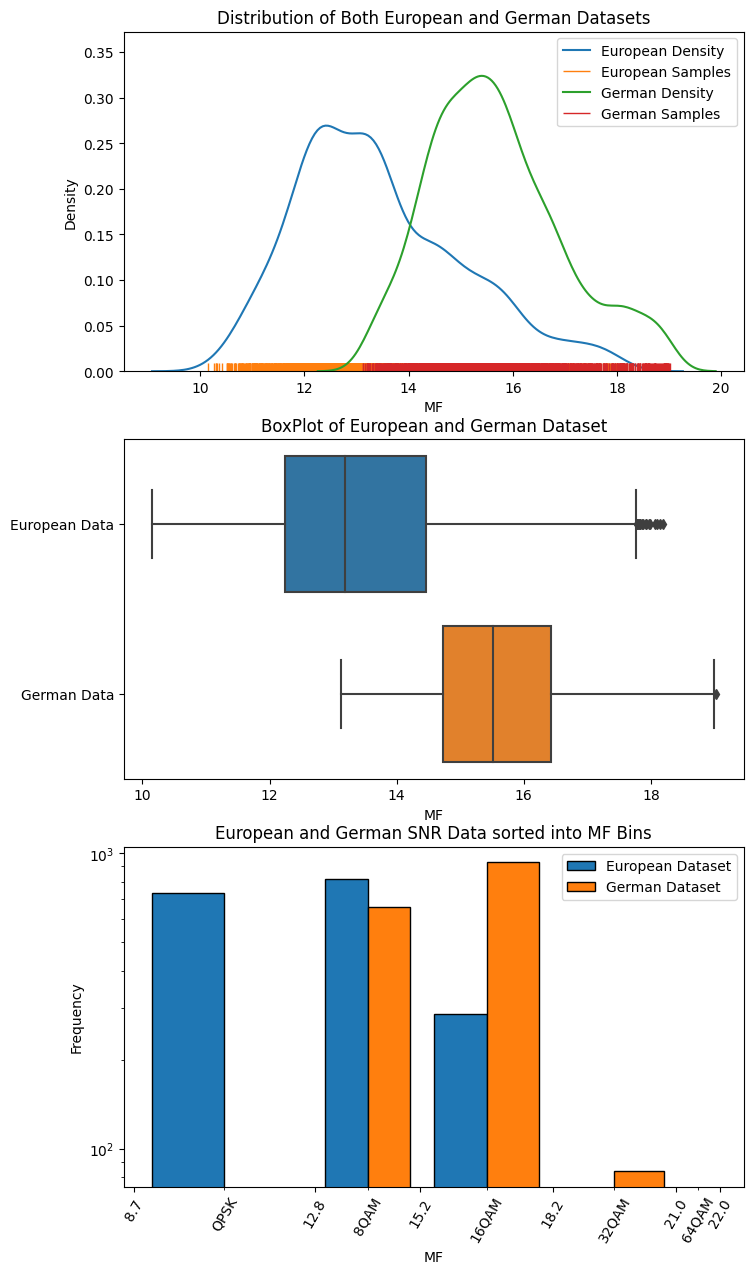

In [8]:
fig, ax = plt.subplots(3,1,figsize=(8, 15));


sns.kdeplot(data=data_e['SNR'], ax=ax[0], label='European Density')
sns.rugplot(data=data_e['SNR'], ax=ax[0], label='European Samples')
sns.kdeplot(data=data_g['SNR'], ax = ax[0], label='German Density')
sns.rugplot(data=data_g['SNR'], ax = ax[0], label='German Samples')
ax[0].set_title("Distribution of Both European and German Datasets")
ax[0].set_xlabel('MF')
ax[0].legend()

sns.boxplot(data=[data_e['SNR'], data_g['SNR']], ax=ax[1], orient='h')
ax[1].set_title("BoxPlot of European and German Dataset")
ax[1].set_xlabel('MF')
ax[1].set_yticklabels(labels=['European Data','German Data'])

labels = ['QPSK', '8QAM', '16QAM', '32QAM', '64QAM']

bins2 = boundries.copy()
bins2.append(max(boundries[-1] + 1, np.max(data_e['SNR']), np.max(data_g['SNR'])))
minor = [np.mean([x,y]) for x, y in zip(bins2, bins2[1:])]

ax[2].hist([data_e['SNR'], data_g['SNR']], bins=bins2, edgecolor='black', log=True)
ax[2].set_title('European and German SNR Data sorted into MF Bins')
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('MF')

ax[2].set_xticks(bins2)
ax[2].set_xticklabels(labels=bins2, rotation=60)
ax[2].legend(['European Dataset', 'German Dataset'])
ax[2].set_xticks(minor, minor=True)
ax[2].set_xticklabels(labels=labels, rotation=60, minor=True)

plt.show()

####Comparing the Mean Across Sets For Each Feature

In [9]:
stats_g = data_g.describe()
stats_e = data_e.describe()

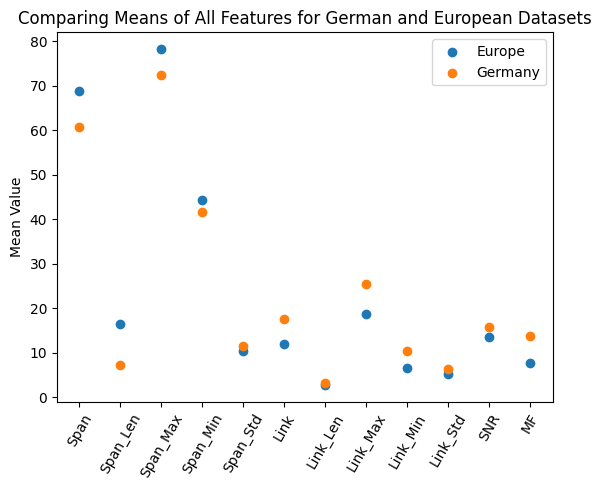

In [10]:
# Concatenate the mean values of the features from two datasets
means = pd.concat([stats_e.iloc[1,:], stats_g.iloc[1,:]], axis=1)
means.columns = ['Europe', 'Germany']

# Create a scatter plot
plt.scatter(range(len(means)), means['Europe'], label='Europe')
plt.scatter(range(len(means)), means['Germany'], label='Germany')

# Set x-axis labels as the feature names
plt.xticks(range(len(means)), means.index,rotation=60)
plt.ylabel('Mean Value')
plt.legend()
plt.title('Comparing Means of All Features for German and European Datasets')

plt.show()


####Statistical Tests to Compare Sets
Apply some statistical tests to quantify and evaluate how different the two datasets are:

In [11]:

for i, col in enumerate(data_e.columns.values):
  print("***********************************************")
  print(f'Feature: {col}\n')
  featureE = data_e[col]
  featureG = data_g[col]

  t_statistic, p_value_t = ttest_ind(featureE, featureG)
  print(f"\tT-Test:\t\t\t Statistic: {t_statistic:5.6f}\tP-Value: {p_value_t}")

  statistic_mw, p_value_mw = mannwhitneyu(featureE, featureG)
  print(f"\tMann-Whitney Test:\t Statistic: {statistic_mw:6.1f}\tP-Value: {p_value_mw}")

  statistic_ks, p_value_ks = ks_2samp(featureE, featureG)
  print(f"\tKolmogorov-Smirnov Test: Statistic: {statistic_ks:2.6f}\tP-Value:{p_value_ks}")


***********************************************
Feature: Span

	T-Test:			 Statistic: 32.756596	P-Value: 1.5515680934372149e-205
	Mann-Whitney Test:	 Statistic: 2440888.0	P-Value: 1.7526840310157266e-202
	Kolmogorov-Smirnov Test: Statistic: 0.500104	P-Value:2.3005706226091853e-199
***********************************************
Feature: Span_Len

	T-Test:			 Statistic: 44.903775	P-Value: 0.0
	Mann-Whitney Test:	 Statistic: 2637468.0	P-Value: 2.118880565844127e-299
	Kolmogorov-Smirnov Test: Statistic: 0.610123	P-Value:3.667417124728446e-304
***********************************************
Feature: Span_Max

	T-Test:			 Statistic: 23.815855	P-Value: 2.5276995753952093e-116
	Mann-Whitney Test:	 Statistic: 2258997.0	P-Value: 4.7764641353010166e-178
	Kolmogorov-Smirnov Test: Statistic: 0.491958	P-Value:1.2364377888669115e-192
***********************************************
Feature: Span_Min

	T-Test:			 Statistic: 8.088207	P-Value: 8.262603750894296e-16
	Mann-Whitney Test:	 Statistic: 180747

We observe extremely low P-values, for all features, no matter the test. Thus, for all cases, we reject the null hypothesis and must conclude that there is a significant difference between the two datasets.

Since our two datasats a statistically very different from eachother, we have to be careful about how be apply transfer learning. In fact, having such dissimilar datasets suggests the pure transfer learning would not be a good fit. The two sets are too different: learning done on one set will not help to made predicitons in the target domain because they are too statistically different.

###Split The Data

In [12]:
def train_test_split2(X, y, test=0.2, ySplitUnravel = True):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test, random_state=4, shuffle=True, stratify=y['MF'])

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  if ySplitUnravel == True:
    y_train_snr = y_train.iloc[:,0].to_numpy().ravel()
    y_train_mf =  y_train.iloc[:,1].to_numpy().ravel()

    y_test_snr = y_test.iloc[:,0].to_numpy().ravel()
    y_test_mf =  y_test.iloc[:,1].to_numpy().ravel()

    return X_train, X_test, y_train_snr, y_train_mf, y_test_snr, y_test_mf
  else:
    return X_train, X_test, y_train, y_test

# Original datasets, split into train/test/validation including seperate target vectors (snr and mf)
G_train, G_test, g_train_snr, g_train_mf, g_test_snr, g_test_mf = train_test_split2(data_g.loc[:, ~data_g.columns.isin(['SNR', 'MF'])], data_g[['SNR', 'MF']], test=0.2)
E_train, E_test, e_train_snr, e_train_mf, e_test_snr, e_test_mf = train_test_split2(data_e.loc[:, ~data_e.columns.isin(['SNR', 'MF'])], data_e[['SNR', 'MF']], test=0.2)


Now we set the `_mf` vectors to have `string` elements instead of `integer` elements. Why? These _mf vectors hold the MF allocation which is like the *class* that SNR value belongs to. We convert to strings to avoid any numerical association with the class.

In [13]:
e_train_mf = [str(i) for i in e_train_mf]
g_train_mf = [str(i) for i in g_train_mf]

e_test_mf = [str(i) for i in e_test_mf]
g_test_mf = [str(i) for i in g_test_mf]


___
#Focus on one model and apply some tranfer learning techniques

##Pure Transfer Learning

###1. Optimize hyperparameters.
Classification model using European train set.

In [14]:
def optimize_classifier(X_train, y_train, space, n_trials):
    #***************************************************************************
    #********* Perform hyperparameter optimization via crossvalidation *********
    def hyperopt_train_test(params_):

      params = {
                  'learning_rate'     : params_['learning_rate'],
                  'n_estimators'      : int(params_['n_estimators']),
                  'max_depth'         : int(params_['max_depth']),
                  'min_samples_leaf'  : int(params_['min_samples_leaf']),
                  'min_samples_split' : int(params_['min_samples_split'])
                }
      model = GradientBoostingClassifier(loss='log_loss',**params, random_state=11)

      return cross_val_score(model, X_train, y_train, cv = 3)

    def f(params):
        acc = hyperopt_train_test(params)
        return {'loss': -acc.mean(), 'status': STATUS_OK, 'loss_variance': np.var(acc, ddof=1)}

    trials = Trials()

    #***************************************************************************
    #******** Print best hyperparameters obtained with crossvalidation *********
    ta = time.time()
    best_params = fmin(fn=f, space=space, algo=tpe.suggest, max_evals=n_trials, trials=trials)
    tb = time.time()

    best_params = hyperopt.space_eval(space, best_params)
    print('Best Params Found by Hyperopt:')
    print(f'{best_params}\n')

    #***************************************************************************
    #********** Print best cv accuracy (across all combos) & duration **********
    best_cv_acc = trials.best_trial['result']['loss']

    print(f'Best CV Accuracy During Hyperopt: {-round(best_cv_acc, 6)}')
    print(f'Cross Validation Duration: {round(tb-ta, 5)} s')

    #***************************************************************************
    #*********** Retrain a new model with best hyperparameters using ***********
    #*********** the entire training set (X_train, y_train) ********************
    best_params_ = {
                  'learning_rate'     : best_params['learning_rate'],
                  'n_estimators'      : int(best_params['n_estimators']),
                  'max_depth'         : int(best_params['max_depth']),
                  'min_samples_leaf'  : int(best_params['min_samples_leaf']),
                  'min_samples_split' : int(best_params['min_samples_split'])
                }
    model = GradientBoostingClassifier(loss='log_loss', **best_params_, random_state=11)

    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()

    scr = model.score(X_train, y_train)
    print(f'Model Score: {scr}')
    #***************************************************************************
    #************* Print training results (train accuracy and duration) ********
    print(f'Training Duration: {round(t1 - t0, 6)} s\n')

    #***************************************************************************
    #************************ Return the trained model *************************
    trials_df = pd.DataFrame()
    for t in trials:
      params = pd.DataFrame(t['misc']['vals'])
      params['loss'] = t['result']['loss']
      params['loss_var'] = t['result']['loss_variance']
      trials_df = pd.concat([trials_df, params], ignore_index=True, axis=0)



    return model, best_cv_acc, trials_df


space_clf = {
     'learning_rate': hp.uniform('learning_rate', 0.001, 0.9),
     'n_estimators' : hp.choice('n_estimators', [200, 150, 125, 100, 75, 50, 25, 20, 15, 10, 5]),
     'max_depth': hp.choice('max_depth', [2, 3, 4, 5, 6, 7, 8, 9, 10]),
     'min_samples_leaf': hp.choice('min_samples_leaf', [1,2,4,8,10,15,20,50]),
     'min_samples_split': hp.choice('min_samples_split', [5,10,15,20,25,30])
    }

clf_opt, clf_opt_score, clf_trials = optimize_classifier(E_train, e_train_mf, space_clf, n_trials=150)


100%|██████████| 150/150 [05:34<00:00,  2.23s/trial, best loss: -0.9447461642473209]
Best Params Found by Hyperopt:
{'learning_rate': 0.26320126756236584, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 20}

Best CV Accuracy During Hyperopt: 0.944746
Cross Validation Duration: 334.94333 s
Model Score: 0.9631650750341064
Training Duration: 0.292938 s



###2. Evaluate
Get some metrics over European test set

In [15]:
e_pred_clf = clf_opt.predict(E_test)

acc = accuracy_score(e_test_mf, e_pred_clf)
print(f'Accuracy:\t{100*acc:2.6}%')

labels = np.unique(e_pred_clf)
precision, recall, f, support = precision_recall_fscore_support(e_test_mf, e_pred_clf)

print(f'Classes:\t{labels}')
print(f'Support:\t{support}')

print(f'Precision:\t{precision}\tAvg: {100*precision.mean():2.6}')
print(f'Recall:\t\t{recall}\tAvg: {100*recall.mean():2.6}')
print(f'FScore:\t\t{f}\tAvg: {100*f.mean():2.6}')


Accuracy:	94.2779%
Classes:	['16' '4' '8']
Support:	[ 57 147 163]
Precision:	[0.94736842 0.94594595 0.9382716 ]	Avg: 94.3862
Recall:		[0.94736842 0.95238095 0.93251534]	Avg: 94.4088
FScore:		[0.94736842 0.94915254 0.93538462]	Avg: 94.3969


###3. Apply PURE transfer learning
Directly predict samples from German dataset

In [16]:
g_pred_clf = clf_opt.predict(G_train)

acc = accuracy_score(g_train_mf, g_pred_clf)
print(f'Accuracy:\t{100*acc:2.6}%')

labels2 = np.unique(g_pred_clf)
precision, recall, f, support = precision_recall_fscore_support(g_train_mf, g_pred_clf, zero_division=False)

print(f'Classes:\t{labels}')
print(f'Support:\t{support}')

print(f'Precision:\t{precision}\tAvg: {100*precision.mean():2.6}')
print(f'Recall:\t\t{recall}\tAvg: {100*recall.mean():2.6}')
print(f'FScore:\t\t{f}\tAvg: {100*f.mean():2.6}')


Accuracy:	9.42408%
Classes:	['16' '4' '8']
Support:	[744  67   0 526]
Precision:	[0.62146893 0.         0.         0.0311284 ]	Avg: 16.3149
Recall:		[0.14784946 0.         0.         0.03041825]	Avg: 4.45669
FScore:		[0.23887079 0.         0.         0.03076923]	Avg: 6.741


###Results: Pure Transfer Learning
Clearly, Pure TL performed quite poorly. Why? There was no actual *transfer* of *learning*. We trained a model with only samples from one dataset and tried to leverage the learning done exclusively on that set to try to predict samples from another dataset.



##Domain adaptation
"Inoculating" the model with some samples from the target domain (german dataset) might be a better fit for our usecase. We try the following method.

###1. Retrieve cross-validation performance values & Refit
From European training set and refit our classifier that has already tuned its hyperparameters.

In [17]:

# Get cross-validation values
cv_e = cross_val_score(clf_opt, E_train, e_train_mf)
print(f'Optimized Model over European set\nCross Validation: {cv_e}')
print(f'Average: {100*cv_e.mean():2.4}%')

# Refit over entire dataset
clf_opt = clf_opt.fit(E_train, e_train_mf)

Optimized Model over European set
Cross Validation: [0.95238095 0.94197952 0.93515358 0.93515358 0.94539249]
Average: 94.2%


###2. Get interim performance measure
Evaluate performance over European test set (again).

In [18]:
# Let's see how we perform over European test set
e_hat = clf_opt.predict(E_test)
accuracy_e = accuracy_score(e_test_mf, e_hat)
print(f'Accuracy over European test set: {100*accuracy_e:2.4f}%')

Accuracy over European test set: 94.2779%


###3. Domain Adaptation: Fine-tine the model.
Take the original model that has been trained over the European training set and use it as a starting point for a new model. The new model is going to then continue learning with samples from the German dataset.

In [19]:
da_model = GradientBoostingClassifier(init=clf_opt, learning_rate=0.001)

# Concatenate training set from europe with test set from germany
X_combined = np.concatenate([E_train, G_test], axis=0)
y_combined = np.concatenate([e_train_mf, g_test_mf], axis=0)

shuffle_indices = np.random.permutation(len(X_combined))

X_shuffled = X_combined[shuffle_indices]
y_shuffled = y_combined[shuffle_indices]



cv_da = cross_val_score(da_model, X_shuffled, y_shuffled)

print(f'Optimized Model over New Domain (German set)\nCross Validation: {cv_da}')
print(f'Average: {100*cv_da.mean():2.4}%')

da_model = da_model.fit(X_shuffled, y_shuffled)


Optimized Model over New Domain (German set)
Cross Validation: [0.92797784 0.93055556 0.925      0.95833333 0.92777778]
Average: 93.39%


The results in the cross validation show that we should yield a pretty good performance.


###4. Results: Domain Adaptation
Aaaaaaand drumrollllll... the final nail in the coffin... let's evaluate the performance of the German test set to acquire a final stamp on the accuracy of our model.

In [20]:
g_hat = da_model.predict(G_test)
accuracy_g = accuracy_score(g_test_mf, g_hat)
print(f'Accuracy over German test set: {100*accuracy_g:2.4f}%')

Accuracy over German test set: 97.9104%


###5. Examine knowledge retention
Let's take a step back and see how much information was retained in our model by evaluting performance over European sets again.

>Recall: The **original model** trained on the _european train_ set was used to _initialize_ our domain adapted model. The **domain-adapted model** was trained on the _european train_ set **+** _germany test_ set.
>
>The **original model** was tested against the _european test_ set, whereas the **domain-adapted model** has never explicitly seen the european test set.

In [21]:
e_hat2 = da_model.predict(E_test)
accuracy_e2 = accuracy_score(e_test_mf, e_hat2)
print(f'Accuracy over European test set: {100*accuracy_e2:2.4f}%')

e_hat3 = da_model.predict(E_train)
accuracy_e3 = accuracy_score(e_train_mf, e_hat3)
print(f'Accuracy over European train set: {100*accuracy_e3:2.4f}%')

Accuracy over European test set: 94.8229%
Accuracy over European train set: 95.7708%


**Overview of the two methods:**

_Pure TL_

* Train a model over european train set.
* Evaluate model over european test set.
* Evaluate model over german train* set.

>*Here, _train_ is a bit of a misnomer. We are simply using the larger partition of the german dataset to make the final evaluation

_Domain Adaptation_

* Train a model (A) over european train set.
* Evaluate model over european test set.
* Train a new model (B) over a re-shuffled set that includes the german test* set and european train set that is initialized with model A.
* Evaluate model over german train* set.

>*Again, regarding the german sets, _train_ and _test_ are misnomers. The main point is that the smaller partition of the german set is used to introduce the model to some samples from the german set, and the larger parition is used to evaluate the domain-adapted model. This way, both methods were tested against the same set (the larger partition of the german set, ie the german train set).